#  TC contest
 


In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModel
from datasets import load_dataset
from tensorflow.keras.mixed_precision import set_global_policy

In [ ]:
# from tensorflow.keras import backend as K
# K.clear_session()

In [ ]:
# print(tf.__version__)
# print(transformers.__version__)

In [2]:
gpu = tf.config.list_physical_devices()[1]
tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
set_global_policy('mixed_float16') # mixed-precision training

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


## Loading the Data

In [4]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
train = dataset['train'].to_pandas()
test = dataset['validation'].to_pandas()

In [5]:
train = train.groupby('label').head(1000)
test = train.groupby('label').head(300)

In [6]:
def sample_labels(df, n_per_label):
    return df.groupby('label').apply(lambda x: x.sample(n=n_per_label)).reset_index(drop=True)

# Sample 150 of each label
val = sample_labels(test, 150)

sampled_indices = val.index

test = test.drop(sampled_indices).groupby('label').head(150).reset_index(drop=True)

In [7]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
    
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

val['text'] = val['text'].apply(lambda x : remove_url(x))
val['text'] = val['text'].apply(lambda x : remove_punct(x))
val['text'] = val['text'].apply(lambda x : remove_emoji(x))
val['text'] = val['text'].apply(lambda x : decontraction(x))
val['text'] = val['text'].apply(lambda x : seperate_alphanumeric(x))
val['text'] = val['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

## Tokenization

In [8]:
seq_len = 256
batch_size = 8 # this may be what is causing memory error on my (Mairi) computer

model_name = "google/bert_uncased_L-2_H-128_A-2"

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

x_train = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='tf'
)

x_val = tokenizer(
    val['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='tf'
)


y_train = train['label'].values
y_val = val['label'].values

def map_func(input_ids, attention_mask):
    return {'input_ids': input_ids, 'attention_mask': attention_mask}


train_ds = tf.data.Dataset.from_tensor_slices(
    (
        map_func(x_train['input_ids'], x_train['attention_mask']), 
        y_train
    )
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        map_func(x_val['input_ids'], x_val['attention_mask']), 
        y_val
    )
)


train_ds = train_ds.shuffle(1000).batch(32)
val_ds = val_ds.shuffle(1000).batch(32)

## Model Building

In [9]:
model = TFAutoModel.from_pretrained(model_name,from_pt=True)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer

embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]
# Classifier head
x = tf.keras.layers.Dense(128, activation='relu')(embeddings) # was originally 512
# x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(3, activation=None, name='outputs')(x) # setting activation to None instead of softmax and using from_logits=True for numerical stability

my_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # this is the default value for Adam, but the example I took this from used 1e-5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy()

my_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [10]:
history = my_model.fit(
    train_ds,
    epochs=10, 
    batch_size=batch_size,
    validation_data=val_ds
)

Epoch 1/10
94/94 [==============================] - 19s 91ms/step - loss: 0.9447 - sparse_categorical_accuracy: 0.5653 - val_loss: 0.6809 - val_sparse_categorical_accuracy: 0.7667
Epoch 2/10
94/94 [==============================] - 7s 74ms/step - loss: 0.5162 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.3001 - val_sparse_categorical_accuracy: 0.9111
Epoch 3/10
94/94 [==============================] - 7s 73ms/step - loss: 0.2538 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.1886 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/10
94/94 [==============================] - 7s 73ms/step - loss: 0.1422 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.1098 - val_sparse_categorical_accuracy: 0.9733
Epoch 5/10
94/94 [==============================] - 7s 77ms/step - loss: 0.0847 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.0350 - val_sparse_categorical_accuracy: 0.9889
Epoch 6/10
94/94 [==============================] - 7s 79ms/step - loss: 0.0668 - sparse_categorical_acc

In [11]:
x_test = tokenizer(
    test['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
)

y_test = test['label'].values

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        map_func(x_test['input_ids'], x_test['attention_mask']), 
        y_test
    )
)

test_ds = test_ds.shuffle(1000).batch(32)

## Model Evaluation

In [12]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['sparse_categorical_accuracy'], label='binary_accuracy')
    plt.plot(r.history['val_sparse_categorical_accuracy'], label='val_binary_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend();

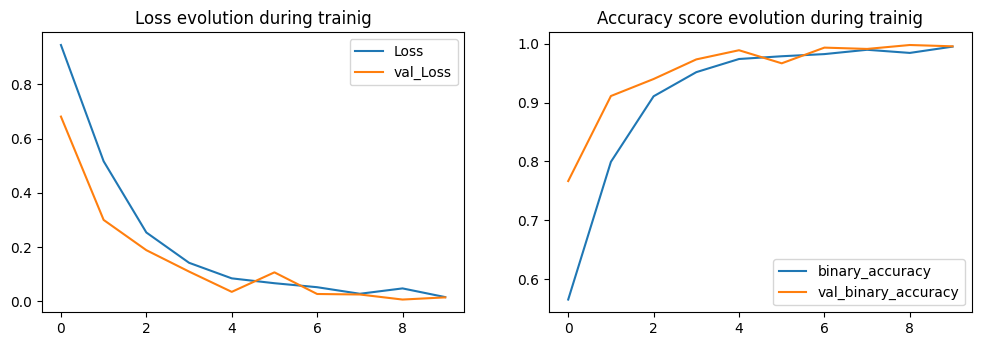

In [13]:
plot_learning_evolution(history)

In [14]:
my_model.evaluate(test_ds)

12/12 [==============================] - 1s 47ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9972


[0.0058617484755814075, 0.9971751570701599]